In [195]:
import warnings

warnings.filterwarnings(action="ignore", message="Torchmetrics v0.9")

In [196]:
import pandas as pd

In [197]:
original_df = pd.read_excel("Data/rebar12price.xls")
original_df.head()

,date,price
0,2018-01-01,36699.994012
1,2018-01-02,36699.994012
2,2018-01-03,36699.994012
3,2018-01-04,36699.994012
4,2018-01-05,36699.994012


In [198]:
original_df["timestamp"] = pd.to_datetime(original_df["date"])
original_df["target"] = original_df["price"]
original_df.drop(columns=["date", "price"], inplace=True)
original_df["segment"] = "main"
original_df.head()

,timestamp,target,segment
0,2018-01-01,36699.994012,main
1,2018-01-02,36699.994012,main
2,2018-01-03,36699.994012,main
3,2018-01-04,36699.994012,main
4,2018-01-05,36699.994012,main


In [199]:
from etna.datasets.tsdataset import TSDataset

df = TSDataset.to_dataset(original_df)
df.head()

segment,main
feature,target
timestamp,
2018-01-01,36699.994012
2018-01-02,36699.994012
2018-01-03,36699.994012
2018-01-04,36699.994012
2018-01-05,36699.994012


In [200]:
ts = TSDataset(df, freq="D")

In [201]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2018-01-01    2024-02-13    2235            0


In [202]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2018-01-01,2024-02-13,2235,0,1,0,0,0,D


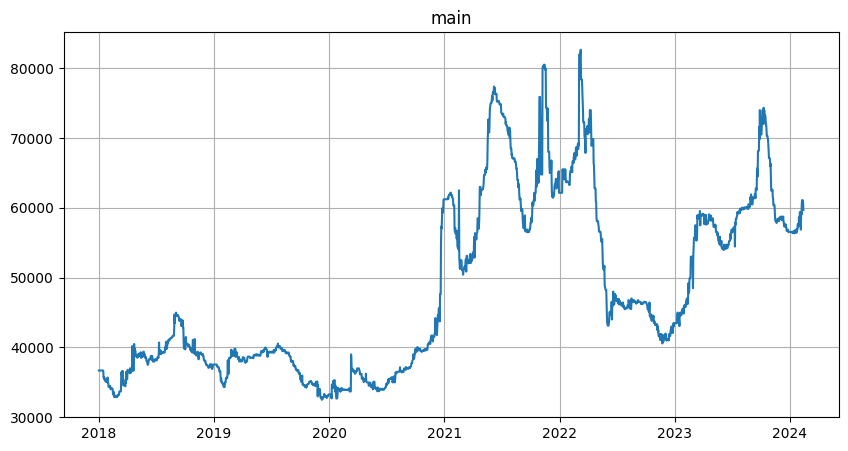

In [203]:
ts.plot()

In [204]:
warnings.filterwarnings("ignore")

In [205]:
HORIZON = 60

In [206]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

In [207]:
from etna.models import NaiveModel
from etna.pipeline import Pipeline

# Define a model
model = NaiveModel(lag=364)

# Define a pipeline
pipeline = Pipeline(model=model, horizon=HORIZON)

In [208]:
# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

In [209]:
forecast_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2023-12-16    2024-02-13      60            0


In [210]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 25.53610667822428}

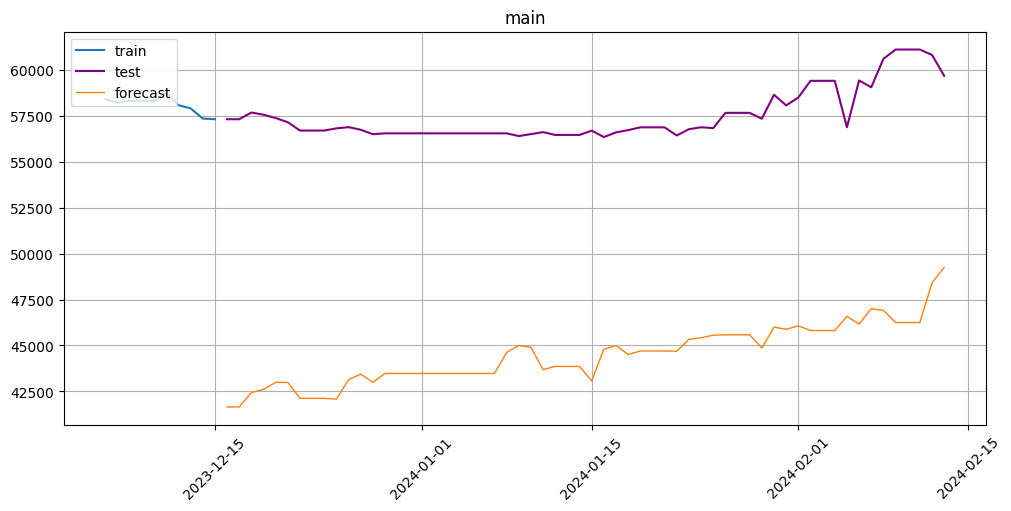

In [211]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=10)

In [212]:
from etna.models import ProphetModel

# Define a model
model = ProphetModel()

# Define a pipeline
pipeline = Pipeline(model=model, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

15:34:04 - cmdstanpy - INFO - Chain [1] start processing
15:34:05 - cmdstanpy - INFO - Chain [1] done processing


In [213]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 16.854380910706052}

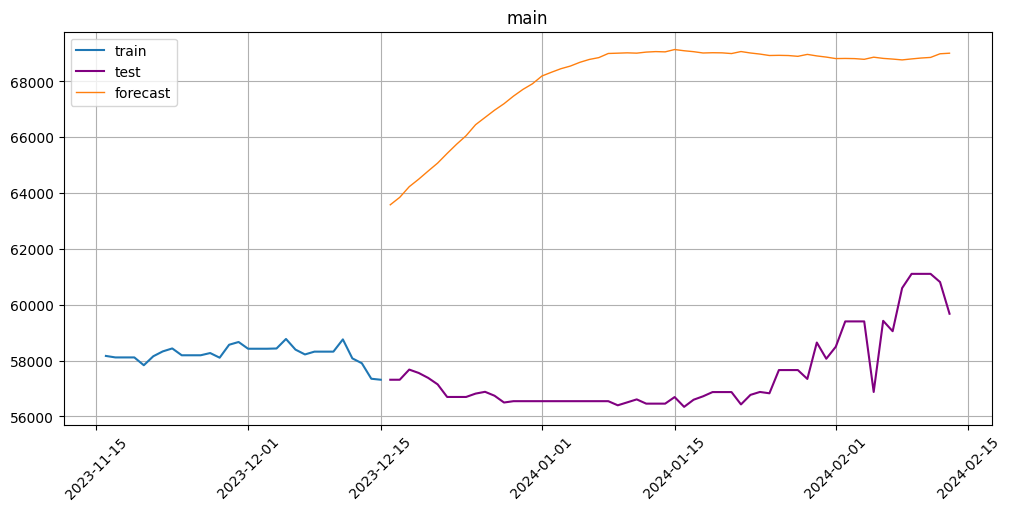

In [214]:
plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=30)

In [215]:
from etna.transforms import LagTransform

lags = LagTransform(in_column="target", lags=list(range(HORIZON, 300)), out_column="lag")

In [216]:
from etna.transforms import MeanTransform

mean = MeanTransform(in_column=f"lag_{HORIZON}", window=12)

In [217]:
from etna.transforms import DateFlagsTransform

date_flags = DateFlagsTransform(
    day_number_in_week=False,
    day_number_in_month=True,
    week_number_in_month=False,
    month_number_in_year=True,
    season_number=True,
    is_weekend=True,
    out_column="date_flag",
)

In [218]:
from etna.transforms import LogTransform

log = LogTransform(in_column="target", inplace=True)

In [219]:
from etna.models import CatBoostMultiSegmentModel

# Define transforms
transforms = [lags, mean, date_flags, log]

# Define a model
model = CatBoostMultiSegmentModel()

# Define a pipeline
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

In [220]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 4.2437404301145545}

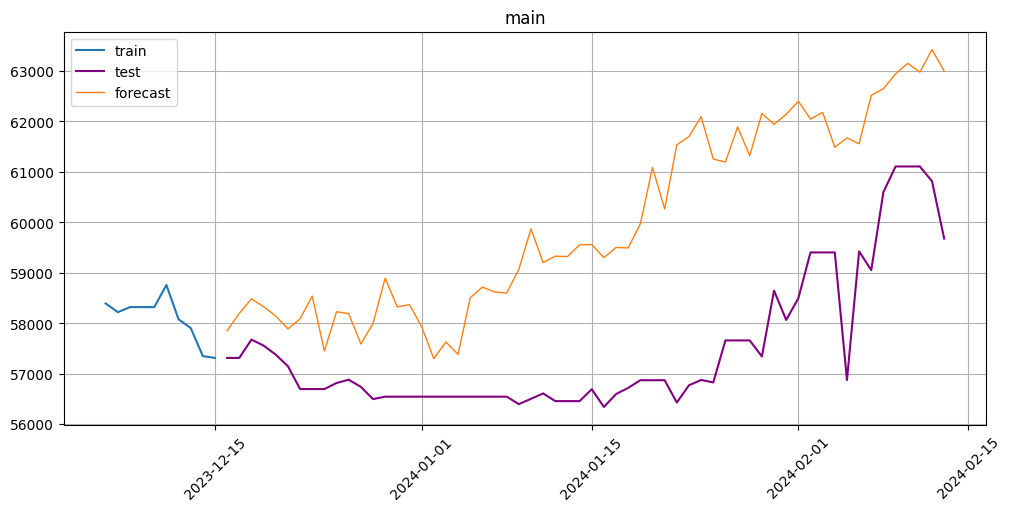

In [221]:
plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=10)